# TIME SERIES MODELING

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import env
import acquire
import prepare

Using saas.csv or log data from API usage or store_item_sales

In [2]:
df = acquire.get_store_item_demand_data()

Reading from csv file...
Reading from csv file...
Reading from csv file...


In [3]:
df = prepare.prep_store_data(df)

In [4]:
df.head()

,sales_total,quantity
sale_date,,
2013-01-31,2447368.20,454904.0
2013-02-28,2469765.97,459417.0
2013-03-31,3319815.58,617382.0
2013-04-30,3666901.23,682274.0
2013-05-31,4102278.40,763242.0


# SPLIT DATA

1. Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum.

In [5]:
#Train set at 50% of data set
train_size = int(len(df) * .5)
#Validate set at 30% of data set
validate_size = int(len(df) * .3)
# Test size is the reamining portion of data set
test_size = int(len(df) - train_size - validate_size)
# determine end of validate
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

In [6]:
train.tail(10)

,sales_total,quantity
sale_date,,
2014-09-30,4220256.45,785124.0
2014-10-31,4078573.46,758883.0
2014-11-30,4302315.54,800783.0
2014-12-31,3108354.15,578048.0
2015-01-31,2971740.70,552513.0
2015-02-28,2962257.74,551317.0
2015-03-31,3932960.55,730951.0
2015-04-30,4427214.12,824467.0
2015-05-31,4988111.92,926902.0


In [7]:
validate.head()

,sales_total,quantity
sale_date,,
2015-07-31,5575319.12,1037350.0
2015-08-31,4951252.98,920401.0
2015-09-30,4426326.24,823332.0
2015-10-31,4286868.40,797253.0
2015-11-30,4448745.67,827645.0


# PLOT SPLITS

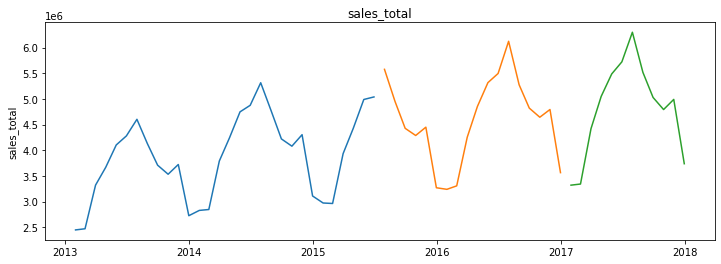

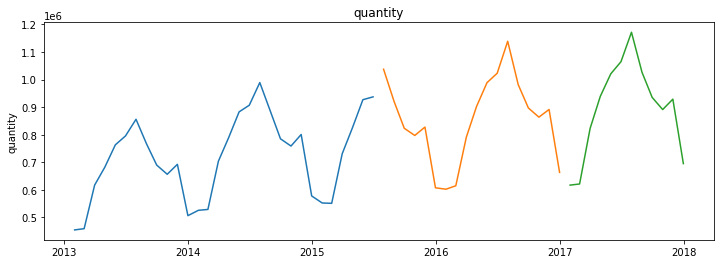

In [8]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [9]:
train.size, validate.size, test.size

(60, 36, 24)

# FUNCTIONS TO ASSIST in FORCASTING

In [10]:
# evaluation function to compute rmse
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [11]:
# plot and evaluate 
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [12]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)


In [13]:
def make_predictions(dollars=None, items=None):
    yhat_df = pd.DataFrame({'dollars_sold': [dollars],
                           'items_sold': [items]},
                          index=validate.index)
    return yhat_df

2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
- Simple Average
- Moving Average
- Holt's Linear Trend Model
- Based on previous year/month/etc., this is up to you.

### Simple Average

#### Make Predictons

In [14]:
# compute simple average to establish the predictions
sales_total = round(train['sales_total'].mean(), 2)
sales_total

3871057.0

In [15]:
# compute simple average to establish the predictions
item_quantity = round(train['quantity'].mean(), 2)
item_quantity

720001.97

In [16]:
#Apply predictions to the observations
def make_predictions(dollars=None, items=None):
    yhat_df = pd.DataFrame({'sales_total': [sales_total],
                           'quantity': [item_quantity]},
                          index=validate.index)
    return yhat_df

In [17]:
yhat_df = make_predictions(sales_total, item_quantity)

In [18]:
yhat_df.head()

,sales_total,quantity
sale_date,,
2015-07-31,3871057.0,720001.97
2015-08-31,3871057.0,720001.97
2015-09-30,3871057.0,720001.97
2015-10-31,3871057.0,720001.97
2015-11-30,3871057.0,720001.97


#### Plot Actual vs. Predicted Values

sales_total -- RMSE: 1087281


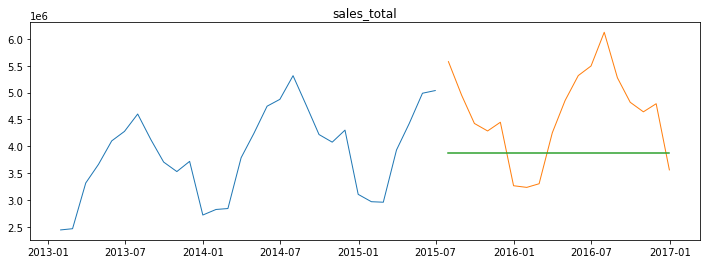

quantity -- RMSE: 202312


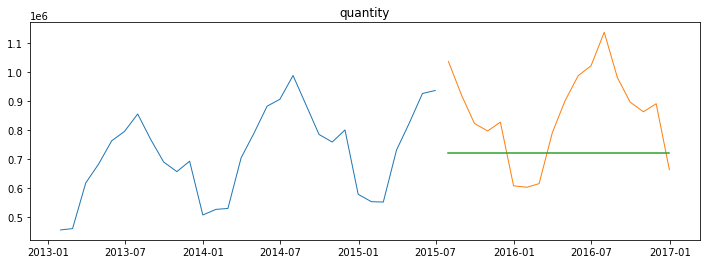

In [19]:
for col in train.columns:
    plot_and_eval(col)

#### Evaluate

In [20]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'simple_average', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,simple_average,sales_total,1087281.0
1,simple_average,quantity,202312.0


### Moving Average

#### Make Predictions

In [21]:
period = 3
sales_total = round(train['sales_total'].rolling(period).mean()[-1],2)
item_quantity = round(train['quantity'].rolling(period).mean()[-1],2)
print(sales_total, item_quantity)

4817695.93 896184.33


In [22]:
yhat_df = make_predictions(sales_total, item_quantity)
yhat_df.head()

,sales_total,quantity
sale_date,,
2015-07-31,4817695.93,896184.33
2015-08-31,4817695.93,896184.33
2015-09-30,4817695.93,896184.33
2015-10-31,4817695.93,896184.33
2015-11-30,4817695.93,896184.33


#### Plot Actual vs. Predicted Values

sales_total -- RMSE: 846105


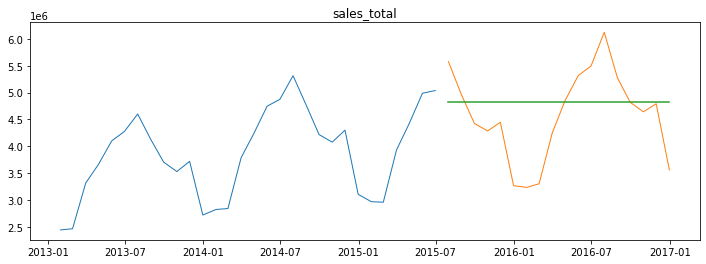

quantity -- RMSE: 157415


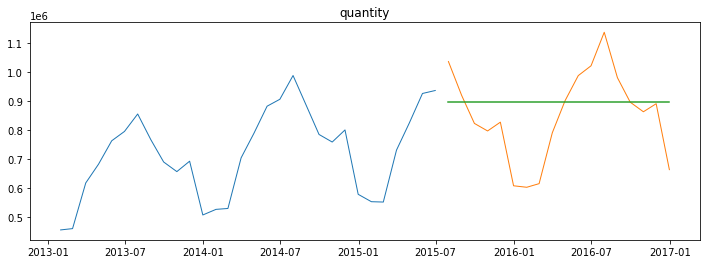

In [23]:
for col in train.columns:
    plot_and_eval(col)

#### Evaluate

In [24]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '3M_moving_avg',
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,simple_average,sales_total,1087281.0
1,simple_average,quantity,202312.0
2,3M_moving_avg,sales_total,846105.0
3,3M_moving_avg,quantity,157415.0


In [25]:
periods = [1, 4, 6, 12]

for p in periods:
    sales_total = round(train['sales_total'].rolling(p).mean()[-1],2)
    item_quantity = round(train['quantity'].rolling(p).mean()[-1],2)
    yhat_df = make_predictions(sales_total, item_quantity)
    model_type = str(p) + '_month_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type, 
                                 target_var = col)

In [26]:
eval_df

,model_type,target_var,rmse
0,simple_average,sales_total,1087281.0
1,simple_average,quantity,202312.0
2,3M_moving_avg,sales_total,846105.0
3,3M_moving_avg,quantity,157415.0
4,1_month_moving_avg,sales_total,929649.0
5,1_month_moving_avg,quantity,172989.0
6,4_month_moving_avg,sales_total,815097.0
7,4_month_moving_avg,quantity,151640.0
8,6_month_moving_avg,sales_total,976250.0
9,6_month_moving_avg,quantity,181664.0


In [27]:
# best performing average
min_sales_rmse = eval_df[eval_df.target_var == 'sales_total']['rmse'].min()
min_quantity_rmse = eval_df[eval_df.target_var == 'quantity']['rmse'].min()

eval_df[((eval_df.rmse == min_sales_rmse) |
         (eval_df.rmse == min_quantity_rmse)
        )]

,model_type,target_var,rmse
6,4_month_moving_avg,sales_total,815097.0
7,4_month_moving_avg,quantity,151640.0


### Holt's Linear Trend Model

#### Seasonal Decomposition

sales_total 



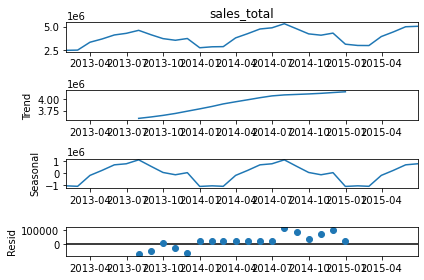

quantity 



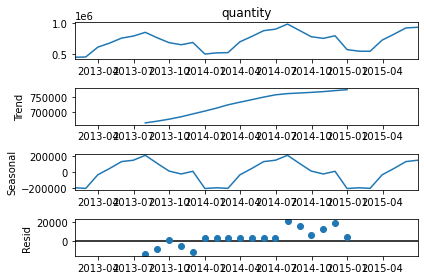

In [28]:
for col in train.columns:
    print(col, '\n')
    sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
    plt.show()

#### Make Predictions

In [29]:
for col in train.columns:
    #create the Holt object
    model = Holt(train[col], exponential=False, damped=True)
    #fit the model
    model = model.fit(optimized=True)
    #make predictions for each date in validate
    yhat_items = model.predict(start = validate.index[0],
                               end = validate.index[-1])
    #add predictions to the yhat_df
    yhat_df[col] = round(yhat_items, 2)

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [30]:
yhat_df

,sales_total,quantity
sale_date,,
2015-07-31,5054157.33,940483.07
2015-08-31,5070565.39,943785.83
2015-09-30,5086809.37,947055.57
2015-10-31,5102890.91,950292.61
2015-11-30,5118811.64,953497.27
2015-12-31,5134573.15,956669.89
2016-01-31,5150177.05,959810.79
2016-02-29,5165624.91,962920.27
2016-03-31,5180918.30,965998.66


#### Plot Actual vs. Predicted Values

sales_total -- RMSE: 1005557


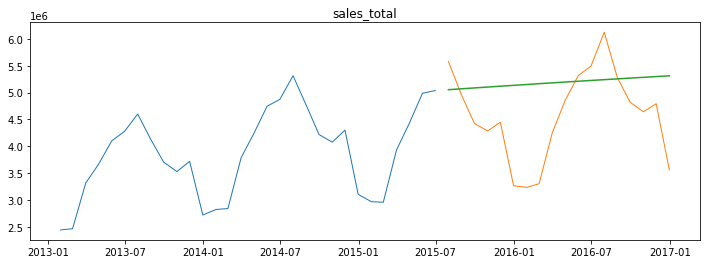

quantity -- RMSE: 188450


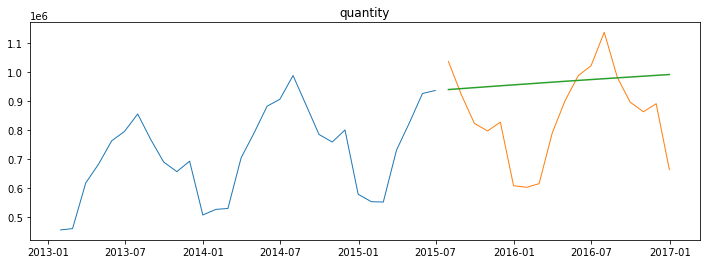

In [31]:
for col in train.columns:
    plot_and_eval(target_var = col)

#### Evaluate

In [32]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized',
                             target_var = col)

In [33]:
eval_df.sort_values(by = 'rmse')

,model_type,target_var,rmse
7,4_month_moving_avg,quantity,151640.0
3,3M_moving_avg,quantity,157415.0
11,12_month_moving_avg,quantity,170156.0
5,1_month_moving_avg,quantity,172989.0
9,6_month_moving_avg,quantity,181664.0
13,holts_optimized,quantity,188450.0
1,simple_average,quantity,202312.0
6,4_month_moving_avg,sales_total,815097.0
2,3M_moving_avg,sales_total,846105.0
10,12_month_moving_avg,sales_total,914659.0


In [34]:
for col in train.columns:
    #create the Holt object
    model = Holt(train[col], exponential=False)
    #fit the model
    model = model.fit(smoothing_level = .1,
                      smoothing_slope = .1,
                      optimized=False)
    #make predictions for each date in validate
    yhat_items = model.predict(start = validate.index[0],
                               end = validate.index[-1])
    #add predictions to the yhat_df
    yhat_df[col] = round(yhat_items, 2)

In [35]:
yhat_df

,sales_total,quantity
sale_date,,
2015-07-31,4596459.52,855377.35
2015-08-31,4639953.13,863429.72
2015-09-30,4683446.73,871482.09
2015-10-31,4726940.34,879534.45
2015-11-30,4770433.94,887586.82
2015-12-31,4813927.55,895639.19
2016-01-31,4857421.15,903691.55
2016-02-29,4900914.75,911743.92
2016-03-31,4944408.36,919796.29


sales_total -- RMSE: 902319


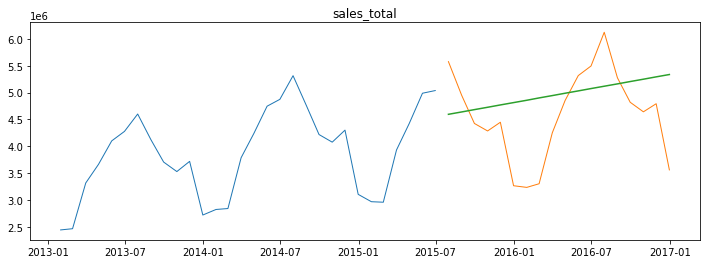

quantity -- RMSE: 167821


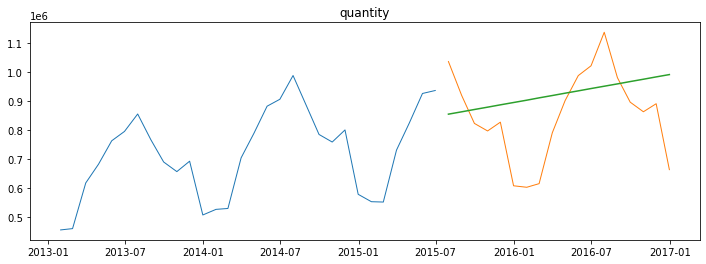

In [36]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [37]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized.1',
                             target_var = col)

In [38]:
eval_df

,model_type,target_var,rmse
0,simple_average,sales_total,1087281.0
1,simple_average,quantity,202312.0
2,3M_moving_avg,sales_total,846105.0
3,3M_moving_avg,quantity,157415.0
4,1_month_moving_avg,sales_total,929649.0
5,1_month_moving_avg,quantity,172989.0
6,4_month_moving_avg,sales_total,815097.0
7,4_month_moving_avg,quantity,151640.0
8,6_month_moving_avg,sales_total,976250.0
9,6_month_moving_avg,quantity,181664.0


### PREVIOUS CYCLE

#### Re-split Data

In [39]:
train = df[: '2015']
validate = df['2016']
test = df['2017']

In [40]:
validate

,sales_total,quantity
sale_date,,
2016-01-31,3237958.05,602439.0
2016-02-29,3305673.92,614957.0
2016-03-31,4252694.79,790881.0
2016-04-30,4851928.10,901950.0
2016-05-31,5316288.92,988730.0
2016-06-30,5494743.33,1022664.0
2016-07-31,6121775.95,1138718.0
2016-08-31,5274888.27,981494.0
2016-09-30,4820008.80,896831.0


In [41]:
print(train.shape)
print(validate.shape)
print(test.shape)

(36, 2)
(12, 2)
(12, 2)


#### Make Predictions

In [42]:
yhat_df = train['2015'] + train.diff(12).mean()

In [43]:
yhat_df.head()

,sales_total,quantity
sale_date,,
2015-01-31,3.329175e+06,618998.166667
2015-02-28,3.319692e+06,617802.166667
2015-03-31,4.290394e+06,797436.166667
2015-04-30,4.784648e+06,890952.166667
2015-05-31,5.345546e+06,993387.166667


In [44]:
yhat_df.shape

(12, 2)

In [45]:
train.loc['2015'].head()

,sales_total,quantity
sale_date,,
2015-01-31,2971740.70,552513.0
2015-02-28,2962257.74,551317.0
2015-03-31,3932960.55,730951.0
2015-04-30,4427214.12,824467.0
2015-05-31,4988111.92,926902.0


In [46]:
#view predictions that will be made for 2016 value
pd.concat([yhat_df.head(1), validate.head(1)])

,sales_total,quantity
sale_date,,
2015-01-31,3.329175e+06,618998.166667
2016-01-31,3.237958e+06,602439.000000


In [48]:
# set yhat_df to index of validate
yhat_df.index = validate.index

In [50]:
yhat_df.shape

(12, 2)

#### Plot and Evaluate

sales_total -- RMSE: 75034


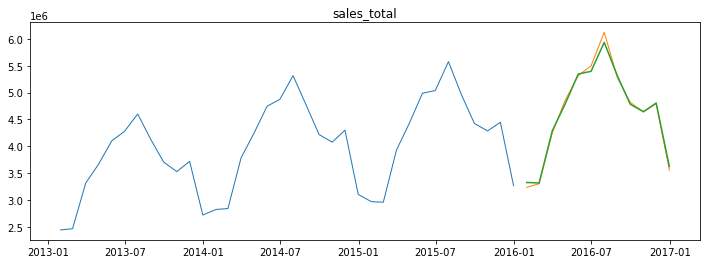

quantity -- RMSE: 13676


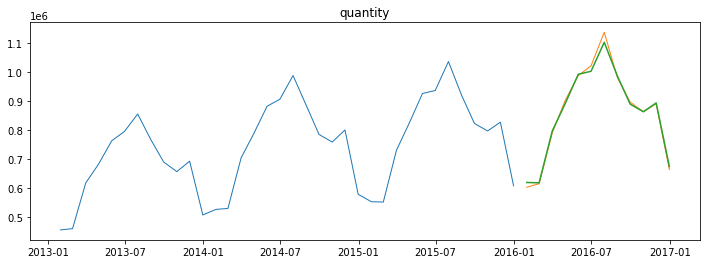

In [51]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous_year',
                             target_var = col)

# Conclusion

In [52]:
# best performing average
min_sales_rmse = eval_df[eval_df.target_var == 'sales_total']['rmse'].min()
min_quantity_rmse = eval_df[eval_df.target_var == 'quantity']['rmse'].min()

eval_df[((eval_df.rmse == min_sales_rmse) |
         (eval_df.rmse == min_quantity_rmse)
        )]

,model_type,target_var,rmse
16,previous_year,sales_total,75034.0
17,previous_year,quantity,13676.0


In [53]:
yhat_df = validate + train.diff(12).mean()
yhat_df.index = test.index

In [54]:
yhat_df

,sales_total,quantity
sale_date,,
2017-01-31,3.595392e+06,6.689242e+05
2017-02-28,3.663108e+06,6.814422e+05
2017-03-31,4.610129e+06,8.573662e+05
2017-04-30,5.209362e+06,9.684352e+05
2017-05-31,5.673723e+06,1.055215e+06
2017-06-30,5.852177e+06,1.089149e+06
2017-07-31,6.479210e+06,1.205203e+06
2017-08-31,5.632322e+06,1.047979e+06
2017-09-30,5.177443e+06,9.633162e+05


In [56]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

In [58]:
rmse_sales = sqrt(mean_squared_error(test['sales_total'], 
                                       yhat_df['sales_total']))

rmse_quantity = sqrt(mean_squared_error(test['quantity'], 
                                       yhat_df['quantity']))

In [59]:
print('rmse-sales-total: ', rmse_sales)
print('rmse-item-quantity: ', rmse_quantity)

rmse-sales-total:  197043.7254737363
rmse-item-quantity:  36642.1370415567


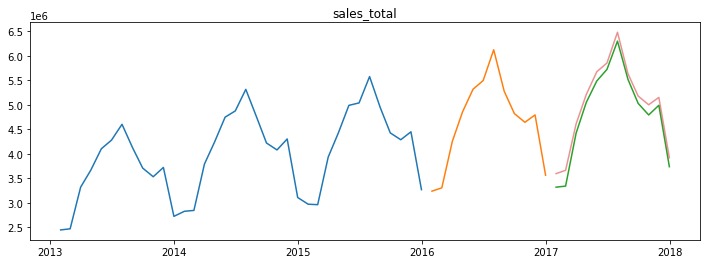

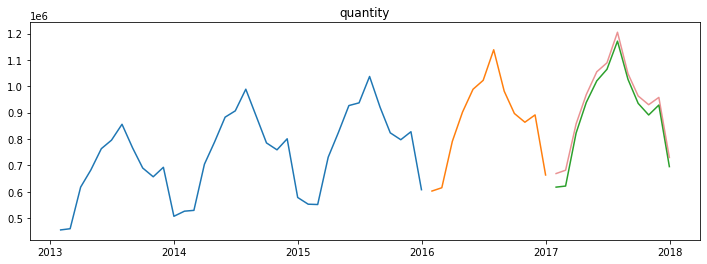

In [61]:
for col in train.columns:
    final_plot(col)

In [63]:
#to predict 2018

yhat_df = test + train.diff(12).mean()
yhat_df.index = test.index + pd.Timedelta('1Y')

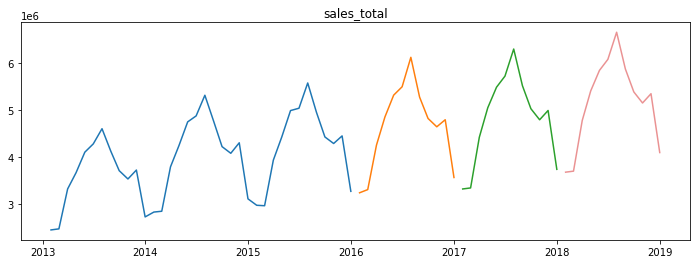

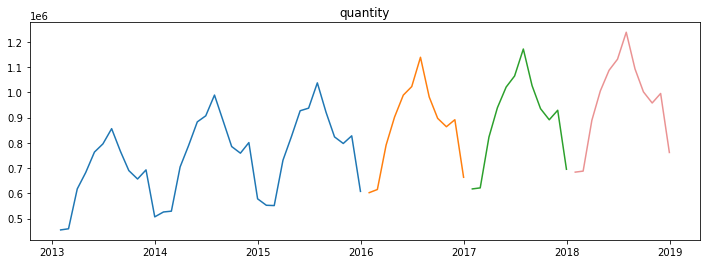

In [64]:
for col in train.columns:
    final_plot(col)

Optional: Using store item demand

1. Predict 2018 total monthly sales for a single store and/or item by creating a model.

2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).

3. Plot the 2018 monthly sales predictions.